### One Node - Runtime Validation

In [2]:
from pydantic import BaseModel

class OverallState(BaseModel):
    a: str
    
def node(state: OverallState):
    return { "a": "I am Arya" } 

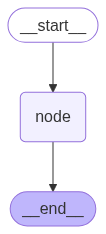

In [3]:
from langgraph.graph import StateGraph, START, END

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node("node", node)

builder.add_edge(START, "node")
builder.add_edge("node", END)

graph = builder.compile()
graph

In [14]:
try:
    # graph.invoke({ "a": "Hello" })
    graph.invoke({ "a": 123 })
except Exception as e:
    print("Exception was raised because a value is integer.", e)

Exception was raised because a value is integer. 1 validation error for OverallState
xyz
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing


### Multiple Nodes - Runtime Validation
Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

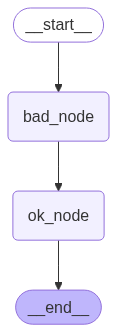

In [10]:
from pydantic import BaseModel

class OverallState(BaseModel):
    xyz: str
    
def bad_node(state: OverallState):
    return { "xyz": 123 }

def ok_node(state: OverallState):
    return { "xyz": "Goodbye!" }

# Build state graph
builder = StateGraph(OverallState)

builder.add_node("bad_node", bad_node)
builder.add_node("ok_node", ok_node)

builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)

graph = builder.compile()
graph

In [13]:
try:
    graph.invoke({ "xyz": 123 })
except Exception as e:
    print("An exception was raised because bad_node sets `xyz` to an integer.", e)

An exception was raised because bad_node sets `xyz` to an integer. 1 validation error for OverallState
xyz
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type


### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.
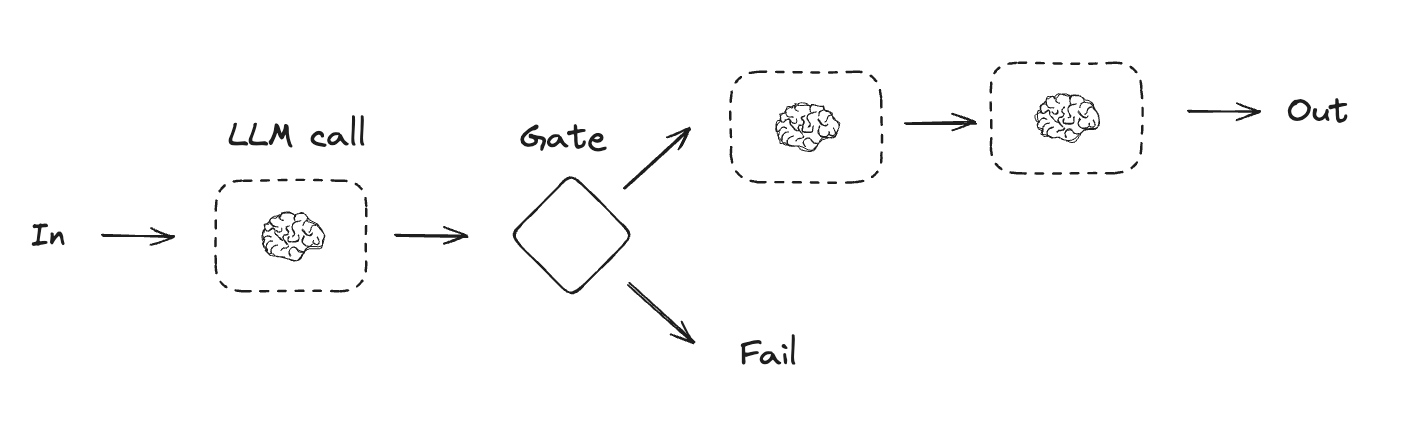

In [15]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

# Load environment variables
load_dotenv()

# Define Gemma2 model
llm = ChatGroq(model="gemma2-9b-it")
llm.invoke("Hi")

AIMessage(content='Hello! 👋  How can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_time': 0.027272727, 'prompt_time': 0.001897329, 'queue_time': 0.264646752, 'total_time': 0.029170056}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--d3864c29-1e84-465b-8c4d-9f27e22b46cf-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26})

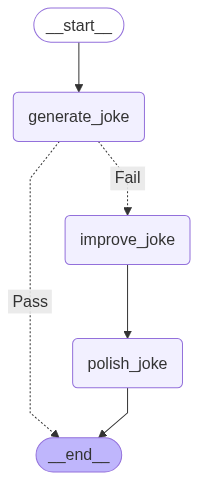

In [19]:
from typing_extensions import TypedDict
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END

# Define graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str
    
# Define node functions
def generate_joke(state: State):
    """ First LLM call to generate initial joke."""
    
    message = llm.invoke(f"Write a short joke about {state['topic']}")
    return { "joke": message.content }

def check_punchline(state: State):
    """ Gate function to check if the joke has a punchline."""
    
    # Simple check - does the joke contains "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """ Second LLM call to improve joke."""
    
    message = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return { "improved_joke": message.content }

def polish_joke(state: State):
    """ Third LLM call for final polish joke."""
    
    message = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return { "final_joke": message.content }

# Build Workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", 
    check_punchline,
    {
        "Fail": "improve_joke",
        "Pass": END
    }
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile 
graph = workflow.compile()

# Display Workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({ "topic": "cats"})

{'topic': 'cats',
 'joke': "Why don't cats play poker in the jungle? \n\nToo many cheetahs! 😹  \n",
 'improved_joke': "Why don't cats play poker in the jungle?\n\nToo many cheetahs trying to **fold** their way to victory! 😹  \n\n\nLet me know if you'd like to try another joke! 😄\n",
 'final_joke': "Why don't cats play poker in the jungle?\n\nToo many cheetahs trying to **fold** their way to victory! 😹 \n\n\nThat's a good one!  Here's a twist:\n\n **Actually, they do play poker in the jungle.  But it's all rigged.  The dealer is a monkey with a banana addiction, and the house always wins.** 🍌🃏 \n\n\n\nWant to try another joke? 😊 \n\n"}